## Inspecting variables in the 2020 CCI Bocquet dataset

This section loads the 2020 NetCDF file (`SIT_sh_c2esaD1_202001_202012.nc`) from `D:\phd\data\Bocquet_2024_cs2` and lists all variable names to help verify dataset contents.

In [2]:
import xarray as xr
from pathlib import Path

data_dir = Path(r"D:\phd\data\Bocquet_2024_cs2")
file_2020 = data_dir / "SIT_sh_c2esaD1_202001_202012.nc"

with xr.open_dataset(file_2020) as ds_2020:
    print("Variables:", list(ds_2020.variables))

Variables: ['sea_ice_freeboard', 'total_freeboard', 'sea_ice_thickness', 'sea_ice_draft', 'ice_concentration', 'ice_density', 'STAT_radar_freeboard_mean', 'STAT_radar_freeboard_median', 'STAT_radar_freeboard_q025', 'STAT_radar_freeboard_q05', 'STAT_radar_freeboard_q1', 'STAT_radar_freeboard_q3', 'STAT_radar_freeboard_q95', 'STAT_radar_freeboard_q975', 'STAT_radar_freeboard_std', 'lat', 'lon', 'STAT_sea_ice_freeboard_mean', 'STAT_sea_ice_freeboard_median', 'STAT_sea_ice_freeboard_q025', 'STAT_sea_ice_freeboard_q05', 'STAT_sea_ice_freeboard_q1', 'STAT_sea_ice_freeboard_q3', 'STAT_sea_ice_freeboard_q95', 'STAT_sea_ice_freeboard_q975', 'STAT_sea_ice_freeboard_std', 'STAT_total_freeboard_mean', 'STAT_total_freeboard_median', 'STAT_total_freeboard_q025', 'STAT_total_freeboard_q05', 'STAT_total_freeboard_q1', 'STAT_total_freeboard_q3', 'STAT_total_freeboard_q95', 'STAT_total_freeboard_q975', 'STAT_total_freeboard_std', 'STAT_sea_ice_thickness_mean', 'STAT_sea_ice_thickness_median', 'STAT_sea_

## Profiling priority variables in the 2020 CCI Bocquet file

The cell below reopens the 2020 dataset and reports core metadata (dimensions, shape, dtype), attribute details, and basic value ranges for the key variables `sea_ice_freeboard`, `total_freeboard`, `lat`, `lon`, `radar_freeboard`, `region_id`, `time`, `x`, and `y`. Use this summary to confirm coverage and detect unexpected data issues before deeper analysis.

In [3]:
import numpy as np
import pandas as pd

vars_to_inspect = [
    "sea_ice_freeboard",
    "total_freeboard",
    "lat",
    "lon",
    "radar_freeboard",
    "region_id",
    "time",
    "x",
    "y",
]

def summarize_variable(var):
    summary = {
        "dims": var.dims,
        "shape": var.shape,
        "dtype": str(var.dtype),
        "attrs": var.attrs,
    }
    # Aggregate stats
    stats = {}
    var_count = var.count()
    stats["valid_count"] = int(var_count.values)
    stats["nan_count"] = int(np.prod(var.shape) - stats["valid_count"])
    if np.issubdtype(var.dtype, np.datetime64):
        stats["min"] = pd.to_datetime(var.min().item()).isoformat()
        stats["max"] = pd.to_datetime(var.max().item()).isoformat()
    else:
        stats["min"] = float(var.min(skipna=True))
        stats["max"] = float(var.max(skipna=True))
    summary["stats"] = stats
    return summary

with xr.open_dataset(file_2020) as ds_2020:
    for name in vars_to_inspect:
        var = ds_2020[name]
        info = summarize_variable(var)
        print(f"\n{name}")
        print("-" * len(name))
        print(f"dims: {info['dims']}")
        print(f"shape: {info['shape']}")
        print(f"dtype: {info['dtype']}")
        print(f"attrs: {info['attrs']}")
        print("stats:")
        for k, v in info["stats"].items():
            print(f"  {k}: {v}")


sea_ice_freeboard
-----------------
dims: ('time', 'y', 'x')
shape: (12, 712, 712)
dtype: float32
attrs: {'standard_name': 'sea_ice_freeboard', 'long_name': 'sea_ice_freeboard', 'comment': 'Sea ice freeboard corresponds to the radar freeboard corrected from the deceleration of the signal penetration in the snow layer using radar propagation speed into snow from Ulaby et al 1986. In this case it corresponds to a weighted mean sea ice freeboard computed from radar_freeboard and an ensemble of snow depth and corresponding snow density products.', 'units': 'm'}
stats:
  valid_count: 777290
  nan_count: 5306038
  min: -1.5909204483032227
  max: 4.9651288986206055

total_freeboard
---------------
dims: ('time', 'y', 'x')
shape: (12, 712, 712)
dtype: float32
attrs: {'standard_name': 'total_freeboard', 'long_name': 'total_freeboard', 'comment': 'Total freeboard corresponds to the sea ice freeboard plus the snow depth. It corresponds to  a weighted mean total freeboard computed from radar_free

## Sector-wise diagnostics for 2020 freeboard fields

The next cell reloads the 2020 file, compiles structural metadata for the priority variables, examines how the projected (`x`, `y`) grid maps to geographic (`lat`, `lon`) coordinates, partitions `sea_ice_freeboard`, `total_freeboard`, and `radar_freeboard` by `region_id`, and then reports sector-level statistics, monthly time series, and spatial footprints across the circumpolar Antarctic domain.

In [5]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path

try:
    file_2020
except NameError:
    data_dir = Path(r"D:\phd\data\Bocquet_2024_cs2")
    file_2020 = data_dir / "SIT_sh_c2esaD1_202001_202012.nc"

if not file_2020.exists():
    raise FileNotFoundError(f"Missing NetCDF file: {file_2020}")

freeboard_vars = ["sea_ice_freeboard", "total_freeboard", "radar_freeboard"]
spatial_vars = ["lat", "lon", "x", "y"]
region_labels = {
    0: "Lake / extended coast",
    1: "Non ocean",
    2: "Weddell Sea",
    3: "Indian Ocean Sector",
    4: "Pacific Ocean Sector",
    5: "Ross Sea",
    6: "Amundsen–Bellingshausen Sea",
    11: "Land",
    12: "Coast",
}
non_ocean_ids = {0, 1, 11, 12}

with xr.open_dataset(file_2020) as ds:
    subset = ds[freeboard_vars + spatial_vars + ["region_id", "time"]]

    # 1. Structural overview of variables
    variable_rows = []
    for name in freeboard_vars + spatial_vars + ["region_id", "time"]:
        da = subset[name]
        variable_rows.append(
            {
                "variable": name,
                "dims": " × ".join(da.dims),
                "dtype": str(da.dtype),
                "units": da.attrs.get("units", ""),
                "description": da.attrs.get("long_name")
                or da.attrs.get("standard_name")
                or da.attrs.get("comment", ""),
            }
        )
    variable_metadata_df = pd.DataFrame(variable_rows).set_index("variable")

    # 2. Relationships among spatial coordinates
    x_vals = subset["x"].values
    y_vals = subset["y"].values
    dx = float(np.median(np.diff(x_vals)))
    dy = float(np.median(np.diff(y_vals)))

    grid_metrics_df = pd.DataFrame(
        [
            {"metric": "x_min_m", "value": float(x_vals.min())},
            {"metric": "x_max_m", "value": float(x_vals.max())},
            {"metric": "x_spacing_median_m", "value": dx},
            {"metric": "y_min_m", "value": float(y_vals.min())},
            {"metric": "y_max_m", "value": float(y_vals.max())},
            {"metric": "y_spacing_median_m", "value": dy},
            {"metric": "lat_min_deg", "value": float(subset["lat"].min())},
            {"metric": "lat_max_deg", "value": float(subset["lat"].max())},
            {"metric": "lon_min_deg", "value": float(subset["lon"].min())},
            {"metric": "lon_max_deg", "value": float(subset["lon"].max())},
            {
                "metric": "approx_grid_cell_area_km2",
                "value": dx * dy / 1e6,
            },
        ]
    )

    sample_indices = [
        (0, 0),
        (0, -1),
        (-1, 0),
        (-1, -1),
        (subset.dims["y"] // 2, subset.dims["x"] // 2),
    ]
    sample_rows = []
    for y_idx, x_idx in sample_indices:
        sample_rows.append(
            {
                "y_idx": int(y_idx if y_idx >= 0 else subset.dims["y"] + y_idx),
                "x_idx": int(x_idx if x_idx >= 0 else subset.dims["x"] + x_idx),
                "x_m": float(subset["x"].isel(x=x_idx)),
                "y_m": float(subset["y"].isel(y=y_idx)),
                "lat_deg": float(subset["lat"].isel(y=y_idx, x=x_idx)),
                "lon_deg": float(subset["lon"].isel(y=y_idx, x=x_idx)),
            }
        )
    spatial_sample_df = pd.DataFrame(sample_rows)

    # 3 & 4. Sectorised statistics, time series, and spatial extents
    region_ids = np.unique(subset["region_id"].values).astype(int)
    ocean_region_ids = sorted(
        int(rid) for rid in region_ids if rid not in non_ocean_ids
    )

    region_stat_records = []
    spatial_extent_records = []
    time_series_frames = []

    region_mask_template = subset["region_id"]

    for rid in ocean_region_ids:
        region_name = region_labels.get(rid, f"Region {rid}")
        region_mask = region_mask_template == rid
        region_footprint = region_mask.any(dim="time")

        lat_masked = subset["lat"].where(region_footprint)
        lon_masked = subset["lon"].where(region_footprint)
        x_masked = subset["x"].where(region_footprint.any(dim="y"))
        y_masked = subset["y"].where(region_footprint.any(dim="x"))

        cell_count = int(region_footprint.sum().item())
        spatial_extent_records.append(
            {
                "region_id": rid,
                "region_name": region_name,
                "grid_cells": cell_count,
                "approx_area_km2": cell_count * dx * dy / 1e6,
                "lat_min_deg": float(lat_masked.min(skipna=True).item()),
                "lat_max_deg": float(lat_masked.max(skipna=True).item()),
                "lon_min_deg": float(lon_masked.min(skipna=True).item()),
                "lon_max_deg": float(lon_masked.max(skipna=True).item()),
                "x_min_m": float(x_masked.min(skipna=True).item()),
                "x_max_m": float(x_masked.max(skipna=True).item()),
                "y_min_m": float(y_masked.min(skipna=True).item()),
                "y_max_m": float(y_masked.max(skipna=True).item()),
            }
        )

        for var in freeboard_vars:
            da = subset[var].where(region_mask)
            valid_count = int(da.count(dim=("time", "y", "x")).item())
            region_stat_records.append(
                {
                    "region_id": rid,
                    "region_name": region_name,
                    "variable": var,
                    "valid_count": valid_count,
                    "mean_m": float(da.mean(skipna=True).item()),
                    "std_m": float(da.std(skipna=True).item()),
                    "min_m": float(da.min(skipna=True).item()),
                    "max_m": float(da.max(skipna=True).item()),
                }
            )

            ts = da.mean(dim=("y", "x"), skipna=True).to_series()
            ts.name = (rid, region_name, var)
            time_series_frames.append(ts)

    region_stats_df = (
        pd.DataFrame(region_stat_records)
        .sort_values(["region_id", "variable"])
        .reset_index(drop=True)
    )
    spatial_extent_df = (
        pd.DataFrame(spatial_extent_records)
        .sort_values("region_id")
        .reset_index(drop=True)
    )
    time_series_df = (
        pd.concat(time_series_frames, axis=1)
        .sort_index(axis=1)
        .round(4)
    )
    time_series_df.columns = pd.MultiIndex.from_tuples(
        time_series_df.columns, names=["region_id", "region_name", "variable"]
    )

    print("Variable metadata overview:")
    print(variable_metadata_df)

    print("\nSpatial grid metrics:")
    print(grid_metrics_df)

    print("\nSample coordinate cross-checks (projected vs geographic):")
    print(spatial_sample_df)

    print("\nRegion-level statistics for freeboard variables (meters):")
    print(region_stats_df.round(4))

    print("\nMonthly mean freeboard by region (meters):")
    print(time_series_df)

    print("\nSpatial footprint of each region (degrees / meters):")
    print(spatial_extent_df.round(3))

C:\Users\xliu38\AppData\Local\Temp\ipykernel_5964\1957626375.py:80: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  (subset.dims["y"] // 2, subset.dims["x"] // 2),
C:\Users\xliu38\AppData\Local\Temp\ipykernel_5964\1957626375.py:87: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "x_idx": int(x_idx if x_idx >= 0 else subset.dims["x"] + x_idx),
C:\Users\xliu38\AppData\Local\Temp\ipykernel_5964\1957626375.py:86: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping fr

Variable metadata overview:
                           dims           dtype          units  \
variable                                                         
sea_ice_freeboard  time × y × x         float32              m   
total_freeboard    time × y × x         float32              m   
radar_freeboard    time × y × x         float32              m   
lat                       y × x         float32  degrees_north   
lon                       y × x         float32   degrees_east   
x                             x         float32              m   
y                             y         float32              m   
region_id          time × y × x           int32              1   
time                       time  datetime64[ns]                  

                                            description  
variable                                                 
sea_ice_freeboard                     sea_ice_freeboard  
total_freeboard                         total_freeboard  
radar_freeboa

## Comprehensive annual spatial distribution matrix (12 months × 4 variables)

This section generates a single integrated figure displaying all monthly spatial distributions for 2020. The figure is organized as a 12-row × 4-column matrix where each row represents a month (January to December, top to bottom) and each column represents a variable: (a) radar freeboard, (b) sea-ice freeboard, (c) total freeboard, and (d) derived snow thickness (total minus sea-ice freeboard). This layout enables systematic comparison of spatial patterns across variables and throughout the annual cycle.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError as exc:
    raise ImportError("Cartopy is required. Install with `pip install cartopy`.") from exc

try:
    file_2020
except NameError:
    data_dir = Path(r"D:\phd\data\Bocquet_2024_cs2")
    file_2020 = data_dir / "SIT_sh_c2esaD1_202001_202012.nc"

non_ocean_ids = {0, 1, 11, 12}

with xr.open_dataset(file_2020) as ds:
    sea_ice_fb = ds["sea_ice_freeboard"].load()
    total_fb = ds["total_freeboard"].load()
    radar_fb = ds["radar_freeboard"].load()
    region_id = ds["region_id"].load()
    lat = ds["lat"].load()
    lon = ds["lon"].load()
    time_coord = ds["time"].load()
    
    snow_thickness = total_fb - sea_ice_fb
    snow_thickness.attrs["long_name"] = "Snow thickness"
    snow_thickness.attrs["units"] = "m"
    
    ocean_mask = ~xr.concat(
        [xr.DataArray(np.isin(region_id.isel(time=t), list(non_ocean_ids)), dims=["y", "x"])
         for t in range(len(time_coord))],
        dim="time"
    ).assign_coords(time=time_coord)

plt.rcParams.update(
    {
        "font.family": "DejaVu Serif",
        "axes.titlesize": 8,
        "axes.labelsize": 7,
        "legend.fontsize": 6,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "figure.dpi": 150,
    }
)

proj = ccrs.SouthPolarStereo()
pc = ccrs.PlateCarree()
extent = [-180, 180, -90, -50]

variables = [
    ("Radar freeboard", radar_fb, "cividis"),
    ("Sea-ice freeboard", sea_ice_fb, "viridis"),
    ("Total freeboard", total_fb, "plasma"),
    ("Snow thickness", snow_thickness, "YlGnBu"),
]

n_months = len(time_coord)
n_vars = len(variables)

fig = plt.figure(figsize=(12, 20))
gs = fig.add_gridspec(
    nrows=n_months,
    ncols=n_vars,
    wspace=0.08,
    hspace=0.25,
    left=0.05,
    right=0.95,
    top=0.97,
    bottom=0.02,
)

for month_idx, timestamp in enumerate(time_coord.values):
    month_label = pd.to_datetime(timestamp).strftime("%B")
    
    for var_idx, (var_name, var_data, cmap) in enumerate(variables):
        ax = fig.add_subplot(gs[month_idx, var_idx], projection=proj)
        ax.set_extent(extent, pc)
        
        data_slice = var_data.isel(time=month_idx).where(ocean_mask.isel(time=month_idx))
        
        valid_data = data_slice.values[~np.isnan(data_slice.values)]
        if len(valid_data) > 0:
            vmin = max(0, np.nanpercentile(valid_data, 2))
            vmax = np.nanpercentile(valid_data, 98)
        else:
            vmin, vmax = 0, 1
        
        mesh = ax.pcolormesh(
            lon,
            lat,
            data_slice,
            transform=pc,
            cmap=cmap,
            shading="auto",
            vmin=vmin,
            vmax=vmax,
        )
        
        ax.add_feature(cfeature.LAND, facecolor="#E0E0E0", edgecolor="#A0A0A0", linewidth=0.2, zorder=2)
        ax.coastlines(resolution="110m", color="#606060", linewidth=0.3, zorder=3)
        
        ax.gridlines(
            draw_labels=False,
            xlocs=np.arange(-180, 181, 90),
            ylocs=np.arange(-90, -49, 20),
            linewidth=0.25,
            color="#888888",
            alpha=0.4,
            zorder=1,
        )
        
        cbar = fig.colorbar(
            mesh,
            ax=ax,
            orientation="horizontal",
            fraction=0.035,
            pad=0.015,
            aspect=35,
            extend="both" if vmin > 0 else "max",
        )
        cbar.set_label("(m)", fontsize=6)
        cbar.ax.tick_params(labelsize=5)
        
        if month_idx == 0:
            ax.set_title(
                f"{var_name}",
                fontsize=9,
                fontweight="bold",
                pad=6,
            )
        
        if var_idx == 0:
            ax.text(
                -0.12,
                0.5,
                month_label,
                transform=ax.transAxes,
                fontsize=9,
                fontweight="semibold",
                rotation=90,
                va="center",
                ha="center",
            )

fig.suptitle(
    "Antarctic Freeboard and Snow Thickness Monthly Spatial Distributions – 2020\n"
    "Rows: January to December (top to bottom) | Columns: Radar freeboard, Sea-ice freeboard, Total freeboard, Snow thickness",
    fontsize=12,
    fontweight="bold",
    y=0.995,
)

plt.show()

print(f"\n✓ Generated comprehensive {n_months}-month × {n_vars}-variable spatial distribution matrix.")

## Extended multi-year analysis: 2021-2023 spatial distributions

This section extends the comprehensive spatial distribution analysis to three additional years of CCI Bocquet data. For each dataset (2021: 12 months, 2022: 12 months, 2023: 6 months), we generate the same 4-variable comparison matrix (radar freeboard, sea-ice freeboard, total freeboard, and derived snow thickness) to enable inter-annual comparison of spatial patterns and seasonal evolution across the 2020-2023 period.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError as exc:
    raise ImportError("Cartopy is required. Install with `pip install cartopy`.") from exc

# Define data directory and file paths
data_dir = Path(r"D:\phd\data\Bocquet_2024_cs2")
datasets = {
    2021: data_dir / "SIT_sh_c2esaD1_202101_202112.nc",
    2022: data_dir / "SIT_sh_c2esaD1_202201_202212.nc",
    2023: data_dir / "SIT_sh_c2esaD1_202301_202306.nc",
}

# Verify all files exist
for year, filepath in datasets.items():
    if not filepath.exists():
        raise FileNotFoundError(f"Missing {year} NetCDF file: {filepath}")

non_ocean_ids = {0, 1, 11, 12}

plt.rcParams.update(
    {
        "font.family": "DejaVu Serif",
        "axes.titlesize": 8,
        "axes.labelsize": 7,
        "legend.fontsize": 6,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "figure.dpi": 150,
    }
)

proj = ccrs.SouthPolarStereo()
pc = ccrs.PlateCarree()
extent = [-180, 180, -90, -50]

# Process each year
for year, filepath in datasets.items():
    print(f"\n{'=' * 80}")
    print(f"Processing year {year}...")
    print(f"{'=' * 80}")
    
    with xr.open_dataset(filepath) as ds:
        sea_ice_fb = ds["sea_ice_freeboard"].load()
        total_fb = ds["total_freeboard"].load()
        radar_fb = ds["radar_freeboard"].load()
        region_id = ds["region_id"].load()
        lat = ds["lat"].load()
        lon = ds["lon"].load()
        time_coord = ds["time"].load()
        
        snow_thickness = total_fb - sea_ice_fb
        snow_thickness.attrs["long_name"] = "Snow thickness"
        snow_thickness.attrs["units"] = "m"
        
        ocean_mask = ~xr.concat(
            [xr.DataArray(np.isin(region_id.isel(time=t), list(non_ocean_ids)), dims=["y", "x"])
             for t in range(len(time_coord))],
            dim="time"
        ).assign_coords(time=time_coord)
        
        variables = [
            ("Radar freeboard", radar_fb, "cividis"),
            ("Sea-ice freeboard", sea_ice_fb, "viridis"),
            ("Total freeboard", total_fb, "plasma"),
            ("Snow thickness", snow_thickness, "YlGnBu"),
        ]
        
        n_months = len(time_coord)
        n_vars = len(variables)
        
        # Adjust figure height based on number of months
        fig_height = 20 if n_months == 12 else 10
        
        fig = plt.figure(figsize=(16, fig_height))
        gs = fig.add_gridspec(
            nrows=n_months,
            ncols=n_vars,
            wspace=0.08,
            hspace=0.25,
            left=0.05,
            right=0.95,
            top=0.97,
            bottom=0.02,
        )
        
        for month_idx, timestamp in enumerate(time_coord.values):
            month_label = pd.to_datetime(timestamp).strftime("%B")
            
            for var_idx, (var_name, var_data, cmap) in enumerate(variables):
                ax = fig.add_subplot(gs[month_idx, var_idx], projection=proj)
                ax.set_extent(extent, pc)
                
                data_slice = var_data.isel(time=month_idx).where(ocean_mask.isel(time=month_idx))
                
                valid_data = data_slice.values[~np.isnan(data_slice.values)]
                if len(valid_data) > 0:
                    vmin = max(0, np.nanpercentile(valid_data, 2))
                    vmax = np.nanpercentile(valid_data, 98)
                else:
                    vmin, vmax = 0, 1
                
                mesh = ax.pcolormesh(
                    lon,
                    lat,
                    data_slice,
                    transform=pc,
                    cmap=cmap,
                    shading="auto",
                    vmin=vmin,
                    vmax=vmax,
                )
                
                ax.add_feature(cfeature.LAND, facecolor="#E0E0E0", edgecolor="#A0A0A0", linewidth=0.2, zorder=2)
                ax.coastlines(resolution="110m", color="#606060", linewidth=0.3, zorder=3)
                
                ax.gridlines(
                    draw_labels=False,
                    xlocs=np.arange(-180, 181, 90),
                    ylocs=np.arange(-90, -49, 20),
                    linewidth=0.25,
                    color="#888888",
                    alpha=0.4,
                    zorder=1,
                )
                
                cbar = fig.colorbar(
                    mesh,
                    ax=ax,
                    orientation="horizontal",
                    fraction=0.035,
                    pad=0.015,
                    aspect=35,
                    extend="both" if vmin > 0 else "max",
                )
                cbar.set_label("(m)", fontsize=6)
                cbar.ax.tick_params(labelsize=5)
                
                if month_idx == 0:
                    ax.set_title(
                        f"{var_name}",
                        fontsize=9,
                        fontweight="bold",
                        pad=6,
                    )
                
                if var_idx == 0:
                    ax.text(
                        -0.12,
                        0.5,
                        month_label,
                        transform=ax.transAxes,
                        fontsize=9,
                        fontweight="semibold",
                        rotation=90,
                        va="center",
                        ha="center",
                    )
        
        # Dynamic title based on data coverage
        if n_months == 12:
            subtitle = "Rows: January to December (top to bottom)"
        else:
            month_range = f"{pd.to_datetime(time_coord[0].item()).strftime('%B')} to {pd.to_datetime(time_coord[-1].item()).strftime('%B')}"
            subtitle = f"Rows: {month_range} (top to bottom)"
        
        fig.suptitle(
            f"Antarctic Freeboard and Snow Thickness Monthly Spatial Distributions – {year}\n"
            f"{subtitle} | Columns: Radar freeboard, Sea-ice freeboard, Total freeboard, Snow thickness",
            fontsize=12,
            fontweight="bold",
            y=0.995,
        )
        
        plt.show()
        
        print(f"✓ Generated {n_months}-month × {n_vars}-variable spatial distribution matrix for {year}")

print(f"\n{'═' * 80}")
print("✓ Multi-year analysis complete: 2021-2023")
print(f"{'═' * 80}")

## Multi-year sector-wise time series analysis (2020-2023)

This section consolidates all four annual datasets (2020-2023) by concatenating the four freeboard variables along the time dimension, partitions the circumpolar domain into six sub-Antarctic sectors based on longitudinal boundaries, and generates a comprehensive time series visualization showing the temporal evolution of radar freeboard, sea-ice freeboard, total freeboard, and derived snow thickness in each sector throughout the 42-month study period.

STEP 1: LOADING AND CONCATENATING MULTI-YEAR DATASETS (2020-2023)
Loading 2020 dataset...
Loading 2021 dataset...
Loading 2022 dataset...
Loading 2023 dataset...

✓ Combined dataset spans: 2020-01 to 2023-06
  Total time steps: 42

STEP 2: DEFINING SUB-ANTARCTIC SECTORS

Western Weddell:
  Longitude: -62° to -40°
  Latitude: -90° to -50°
  Grid cells: 23,334

Eastern Weddell:
  Longitude: -40° to 15°
  Latitude: -90° to -50°
  Grid cells: 58,343

Indian:
  Longitude: 15° to 90°
  Latitude: -90° to -50°
  Grid cells: 79,558

Pacific:
  Longitude: 90° to 160°
  Latitude: -90° to -50°
  Grid cells: 74,253

Ross:
  Longitude: 160° to 180°
  Latitude: -90° to -50°
  Grid cells: 63,648

Amundsen-Bellingshausen:
  Longitude: -140° to -62°
  Latitude: -90° to -50°
  Grid cells: 82,740

STEP 3: COMPUTING SECTOR-AVERAGED TIME SERIES

Processing Western Weddell...
  Radar freeboard: 42/42 valid time steps
  Sea-ice freeboard: 42/42 valid time steps
  Total freeboard: 42/42 valid time steps
  Snow

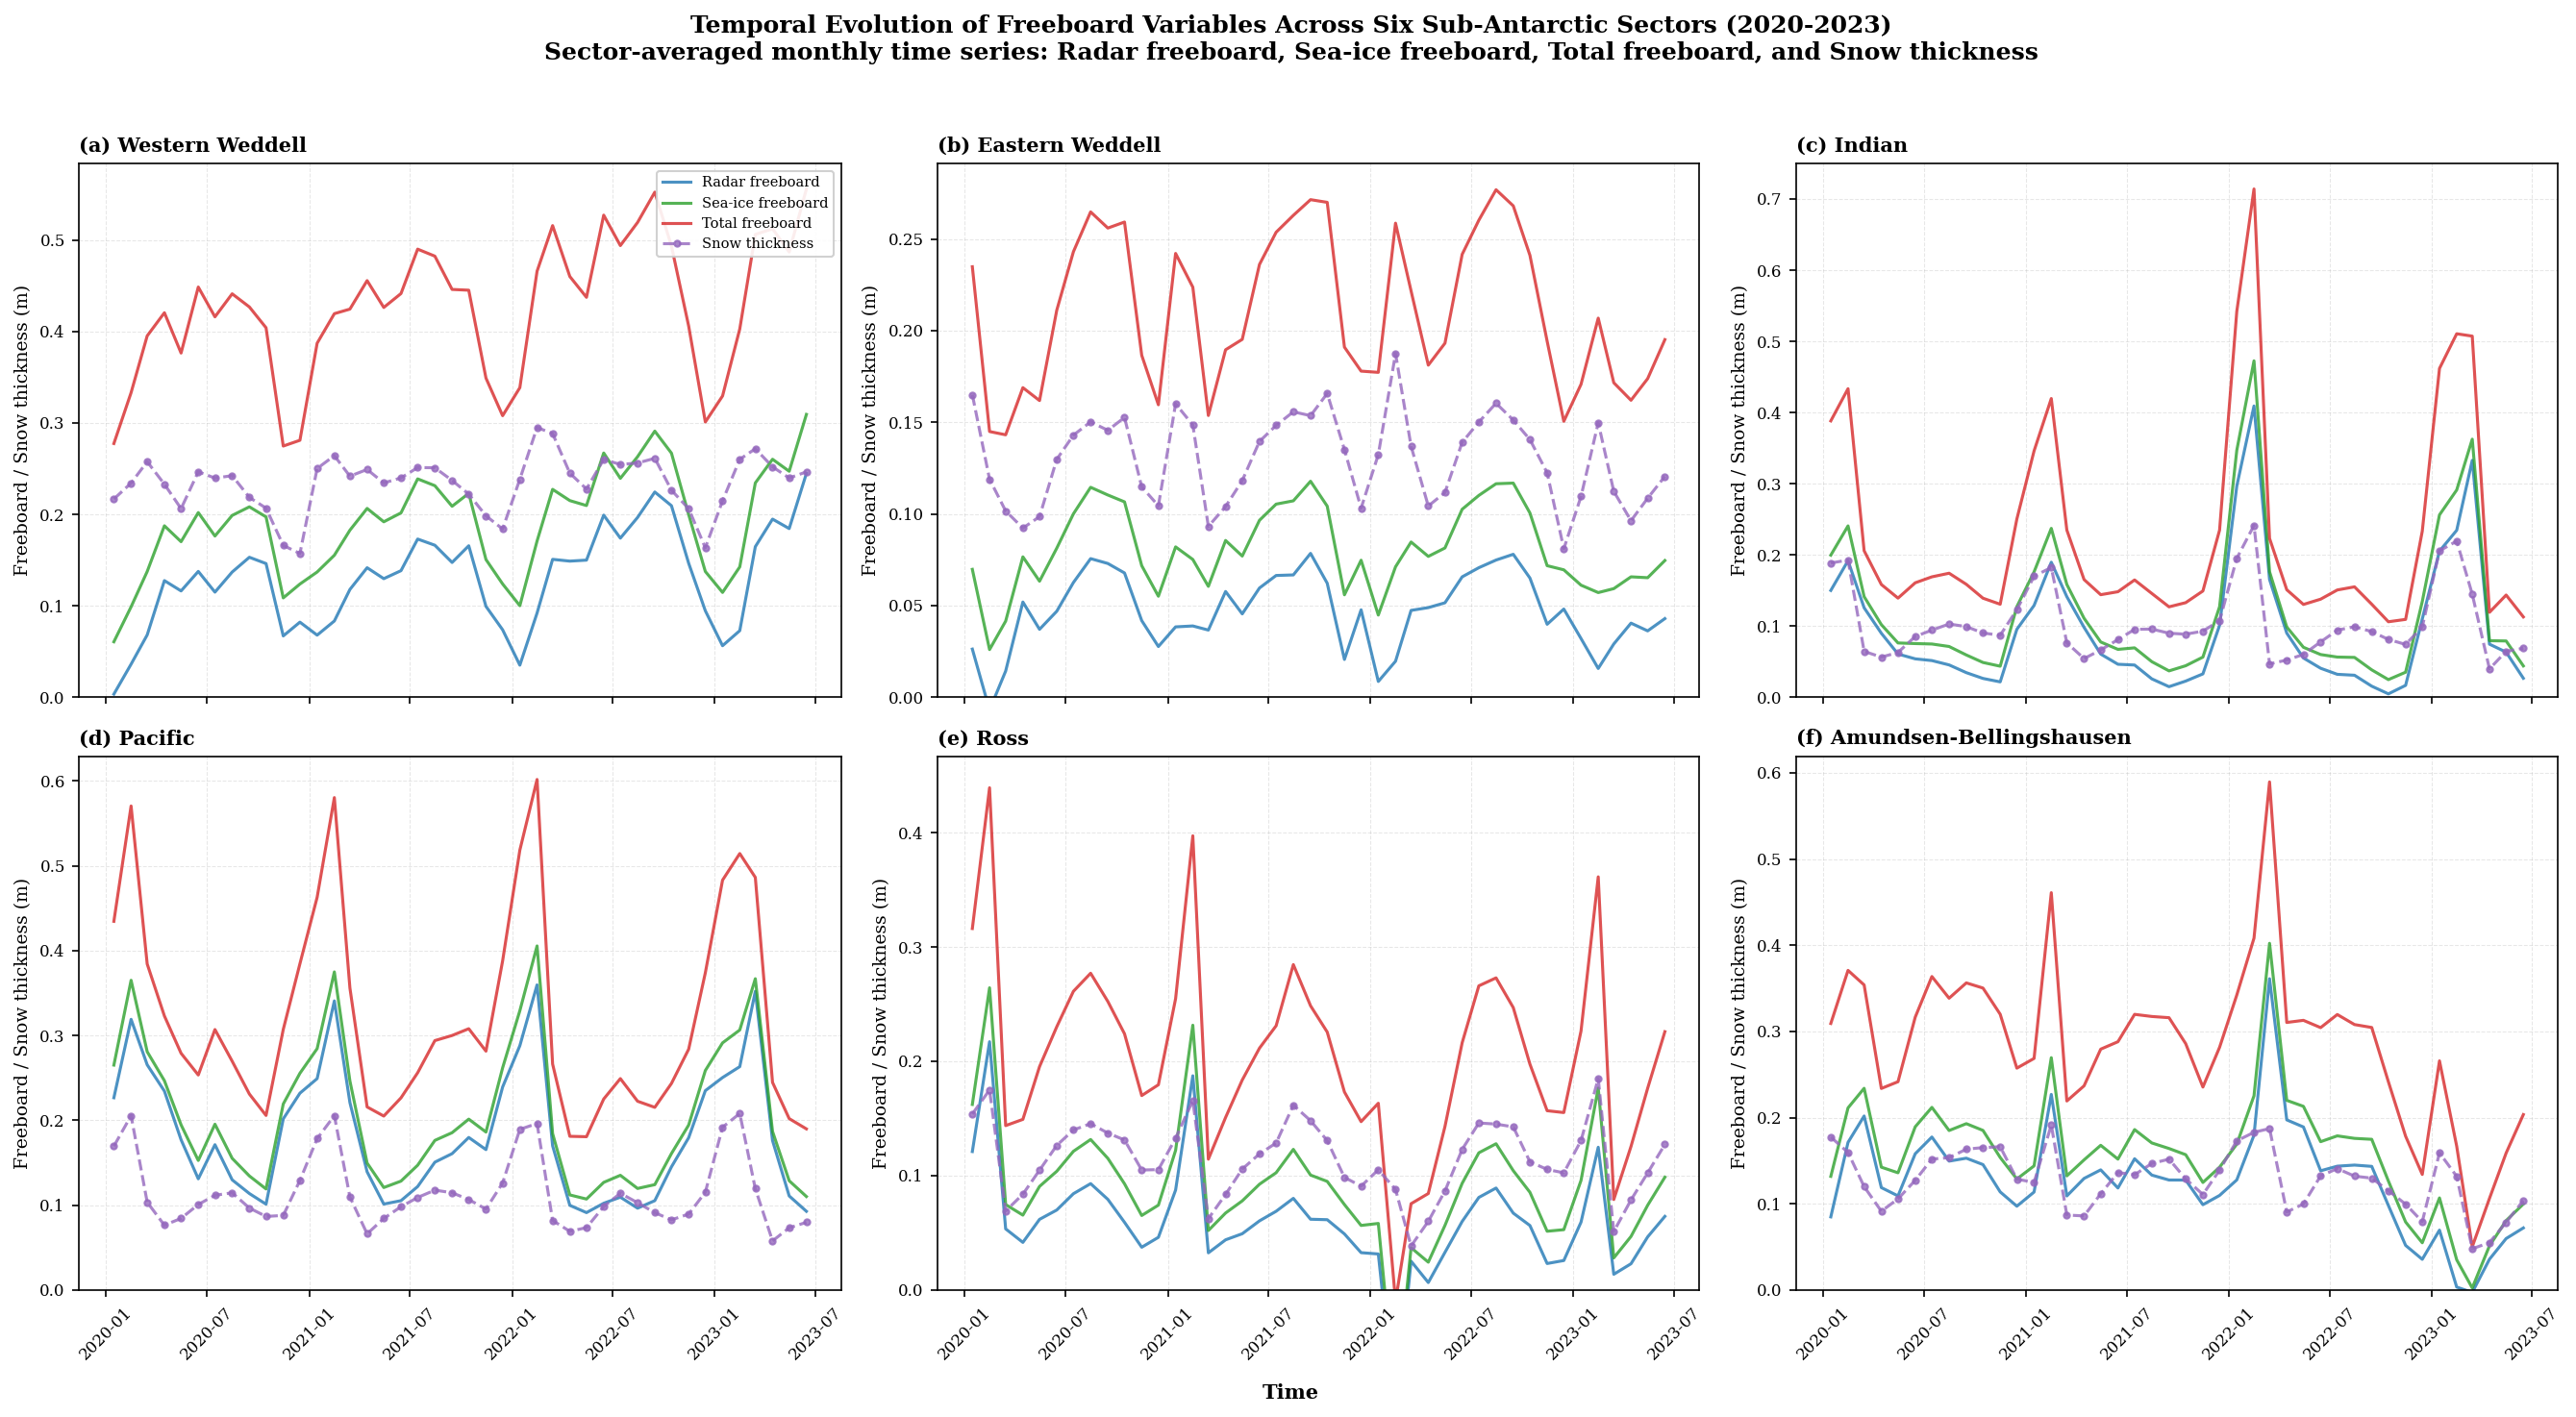


✓ Generated 2×3 multi-sector time series visualization

════════════════════════════════════════════════════════════════════════════════
✓ Multi-year sector-wise analysis complete
════════════════════════════════════════════════════════════════════════════════


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path

# Define data directory and file paths
data_dir = Path(r"D:\phd\data\Bocquet_2024_cs2")
datasets = {
    2020: data_dir / "SIT_sh_c2esaD1_202001_202012.nc",
    2021: data_dir / "SIT_sh_c2esaD1_202101_202112.nc",
    2022: data_dir / "SIT_sh_c2esaD1_202201_202212.nc",
    2023: data_dir / "SIT_sh_c2esaD1_202301_202306.nc",
}

# Verify all files exist
for year, filepath in datasets.items():
    if not filepath.exists():
        raise FileNotFoundError(f"Missing {year} NetCDF file: {filepath}")

print("=" * 80)
print("STEP 1: LOADING AND CONCATENATING MULTI-YEAR DATASETS (2020-2023)")
print("=" * 80)

# Load all datasets and concatenate along time dimension
all_datasets = []
for year, filepath in datasets.items():
    print(f"Loading {year} dataset...")
    ds = xr.open_dataset(filepath)
    all_datasets.append(ds)

# Concatenate along time dimension
ds_combined = xr.concat(all_datasets, dim="time")

# Extract variables
sea_ice_fb = ds_combined["sea_ice_freeboard"]
total_fb = ds_combined["total_freeboard"]
radar_fb = ds_combined["radar_freeboard"]
lat = ds_combined["lat"]
lon = ds_combined["lon"]
time_coord = ds_combined["time"]

# Derive snow thickness
snow_thickness = total_fb - sea_ice_fb
snow_thickness.attrs["long_name"] = "Snow thickness"
snow_thickness.attrs["units"] = "m"

print(f"\n✓ Combined dataset spans: {pd.to_datetime(time_coord[0].item()).strftime('%Y-%m')} to {pd.to_datetime(time_coord[-1].item()).strftime('%Y-%m')}")
print(f"  Total time steps: {len(time_coord)}")

print(f"\n{'=' * 80}")
print("STEP 2: DEFINING SUB-ANTARCTIC SECTORS")
print(f"{'=' * 80}")

# Define six sub-Antarctic sectors
sectors = {
    "Western Weddell": {"lon_min": -62, "lon_max": -40, "lat_min": -90, "lat_max": -50},
    "Eastern Weddell": {"lon_min": -40, "lon_max": 15, "lat_min": -90, "lat_max": -50},
    "Indian": {"lon_min": 15, "lon_max": 90, "lat_min": -90, "lat_max": -50},
    "Pacific": {"lon_min": 90, "lon_max": 160, "lat_min": -90, "lat_max": -50},
    "Ross": {"lon_min": 160, "lon_max": 180, "lat_min": -90, "lat_max": -50},  # Split for dateline
    "Amundsen-Bellingshausen": {"lon_min": -140, "lon_max": -62, "lat_min": -90, "lat_max": -50},
}

# Create masks for each sector
sector_masks = {}
for sector_name, bounds in sectors.items():
    print(f"\n{sector_name}:")
    print(f"  Longitude: {bounds['lon_min']}° to {bounds['lon_max']}°")
    print(f"  Latitude: {bounds['lat_min']}° to {bounds['lat_max']}°")
    
    # Handle Ross sector (crosses dateline)
    if sector_name == "Ross":
        mask = (
            (((lon >= bounds['lon_min']) & (lon <= 180)) | ((lon >= -180) & (lon <= -140))) &
            (lat >= bounds['lat_min']) &
            (lat <= bounds['lat_max'])
        )
    else:
        mask = (
            (lon >= bounds['lon_min']) &
            (lon <= bounds['lon_max']) &
            (lat >= bounds['lat_min']) &
            (lat <= bounds['lat_max'])
        )
    
    sector_masks[sector_name] = mask
    print(f"  Grid cells: {int(mask.sum().item()):,}")

print(f"\n{'=' * 80}")
print("STEP 3: COMPUTING SECTOR-AVERAGED TIME SERIES")
print(f"{'=' * 80}")

# Compute sector-averaged time series for each variable
variables = {
    "Radar freeboard": radar_fb,
    "Sea-ice freeboard": sea_ice_fb,
    "Total freeboard": total_fb,
    "Snow thickness": snow_thickness,
}

sector_time_series = {}
for sector_name, mask in sector_masks.items():
    print(f"\nProcessing {sector_name}...")
    sector_time_series[sector_name] = {}
    
    for var_name, var_data in variables.items():
        # Apply mask and compute spatial mean for each time step
        masked_data = var_data.where(mask)
        ts = masked_data.mean(dim=["y", "x"], skipna=True)
        sector_time_series[sector_name][var_name] = ts
        
        valid_timesteps = (~np.isnan(ts.values)).sum()
        print(f"  {var_name}: {valid_timesteps}/{len(time_coord)} valid time steps")

print(f"\n{'=' * 80}")
print("STEP 4: GENERATING TIME SERIES VISUALIZATION")
print(f"{'=' * 80}")

# Set up plotting parameters
plt.rcParams.update(
    {
        "font.family": "DejaVu Serif",
        "axes.titlesize": 10,
        "axes.labelsize": 9,
        "legend.fontsize": 7,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "figure.dpi": 150,
    }
)

# Create figure with 2 rows × 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
axes = axes.flatten()

# Define colors for each variable
colors = {
    "Radar freeboard": "#1f77b4",
    "Sea-ice freeboard": "#2ca02c",
    "Total freeboard": "#d62728",
    "Snow thickness": "#9467bd",
}

# Define line styles
line_styles = {
    "Radar freeboard": "-",
    "Sea-ice freeboard": "-",
    "Total freeboard": "-",
    "Snow thickness": "--",
}

# Sector order for subplots
sector_order = [
    "Western Weddell",
    "Eastern Weddell",
    "Indian",
    "Pacific",
    "Ross",
    "Amundsen-Bellingshausen",
]

# Plot each sector
for idx, sector_name in enumerate(sector_order):
    ax = axes[idx]
    
    # Plot all four variables for this sector
    for var_name in ["Radar freeboard", "Sea-ice freeboard", "Total freeboard", "Snow thickness"]:
        ts = sector_time_series[sector_name][var_name]
        time_vals = pd.to_datetime(ts.time.values)
        
        ax.plot(
            time_vals,
            ts.values,
            label=var_name,
            color=colors[var_name],
            linestyle=line_styles[var_name],
            linewidth=1.5,
            marker="o" if var_name == "Snow thickness" else None,
            markersize=3,
            alpha=0.8,
        )
    
    # Formatting
    ax.set_title(f"({chr(97 + idx)}) {sector_name}", fontsize=10, fontweight="bold", loc="left")
    ax.set_ylabel("Freeboard / Snow thickness (m)", fontsize=9)
    ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.5)
    ax.set_ylim(bottom=0)
    
    # Add legend only to first subplot
    if idx == 0:
        ax.legend(loc="upper right", framealpha=0.9, fontsize=7)
    
    # Format x-axis
    ax.tick_params(axis="x", rotation=45)

# Set common x-label
fig.text(0.5, 0.02, "Time", ha="center", fontsize=10, fontweight="bold")

# Add main title
fig.suptitle(
    "Temporal Evolution of Freeboard Variables Across Six Sub-Antarctic Sectors (2020-2023)\n"
    "Sector-averaged monthly time series: Radar freeboard, Sea-ice freeboard, Total freeboard, and Snow thickness",
    fontsize=12,
    fontweight="bold",
    y=0.98,
)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

print(f"\n✓ Generated 2×3 multi-sector time series visualization")
print(f"\n{'═' * 80}")
print("✓ Multi-year sector-wise analysis complete")
print(f"{'═' * 80}")

# Close all datasets
ds_combined.close()
for ds in all_datasets:
    ds.close()

## Comprehensive statistical analysis of freeboard variables across six sub-Antarctic sectors (2020-2023)

This section performs detailed statistical analysis on the four freeboard variables (radar freeboard, sea-ice freeboard, total freeboard, and snow thickness) across the six sub-Antarctic sectors throughout the 42-month period. The analysis includes: (1) descriptive statistics (mean, median, standard deviation, min, max, IQR), (2) temporal trend analysis using linear regression, (3) seasonal decomposition to identify annual cycles, (4) inter-sectoral comparison, and (5) comprehensive visualization of statistical metrics including box plots, violin plots, and trend summaries.

✓ Using sector time series from previous analysis

STEP 1: COMPUTING DESCRIPTIVE STATISTICS

Descriptive Statistics Summary:
                 Sector          Variable  Mean (m)  Median (m)  Std Dev (m)   Min (m)  Max (m)   Q1 (m)   Q3 (m)  IQR (m)    CV (%)  N
        Western Weddell   Radar freeboard  0.129355    0.138006     0.054356  0.003434 0.244739 0.085573 0.165388 0.079815 42.021015 42
        Western Weddell Sea-ice freeboard  0.190852    0.199241     0.056677  0.060661 0.309272 0.144556 0.230320 0.085763 29.696836 42
        Western Weddell   Total freeboard  0.425477    0.431982     0.075350  0.274653 0.555701 0.389090 0.485662 0.096571 17.709627 42
        Western Weddell    Snow thickness  0.234625    0.239762     0.030181  0.157163 0.294977 0.219413 0.251758 0.032345 12.863675 42
        Eastern Weddell   Radar freeboard  0.046479    0.047164     0.020523 -0.006911 0.078502 0.036334 0.064440 0.028106 44.154747 42
        Eastern Weddell Sea-ice freeboard  0.080700    0.07

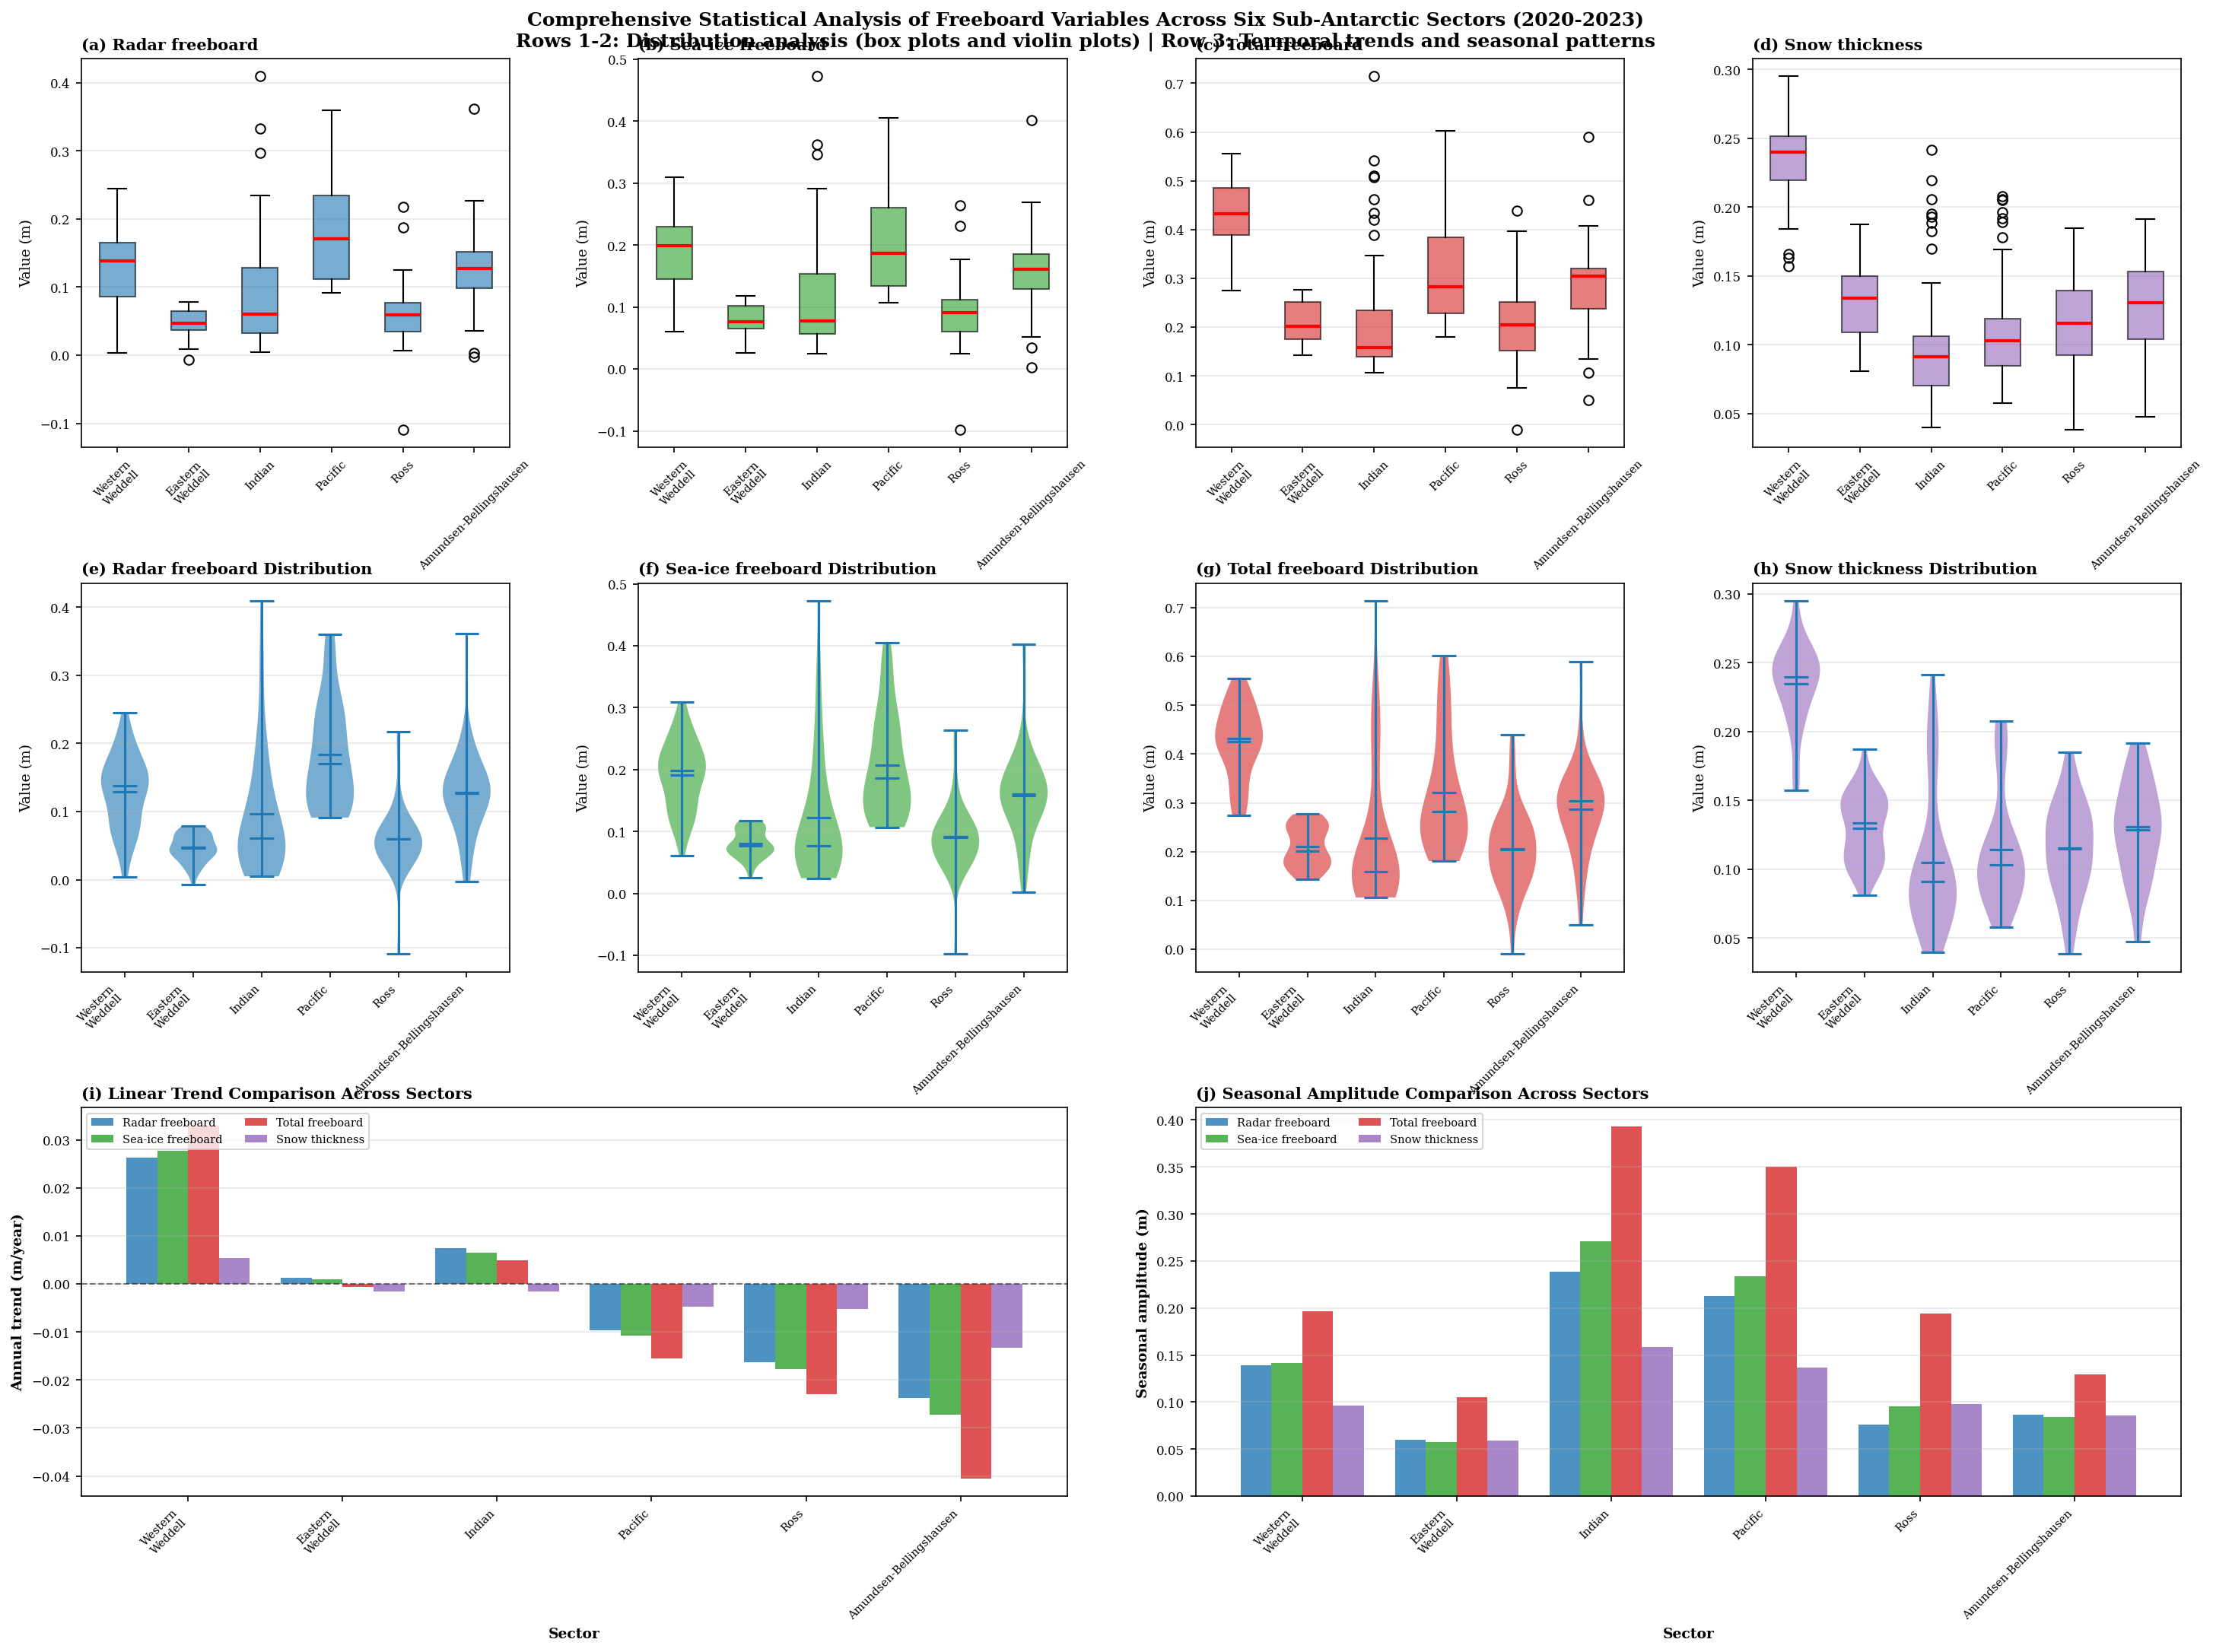


✓ Generated comprehensive statistical visualization with 10 panels

STEP 6: EXPORTING STATISTICAL SUMMARIES

✓ Exported statistical summaries to: C:\Users\xliu38\OneDrive - University of Tasmania\PhD_manuscripts\manuscript2\figures
  - freeboard_descriptive_statistics.csv
  - freeboard_trend_analysis.csv
  - freeboard_seasonal_patterns.csv
  - freeboard_anova_results.csv

════════════════════════════════════════════════════════════════════════════════
✓ COMPREHENSIVE STATISTICAL ANALYSIS COMPLETE
════════════════════════════════════════════════════════════════════════════════


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
from scipy import stats
from scipy.signal import detrend
import warnings
warnings.filterwarnings('ignore')

# Ensure we have the combined dataset from previous cell
try:
    sector_time_series
    print("✓ Using sector time series from previous analysis")
except NameError:
    print("Loading and processing datasets...")
    # Define data directory and file paths
    data_dir = Path(r"D:\phd\data\Bocquet_2024_cs2")
    datasets = {
        2020: data_dir / "SIT_sh_c2esaD1_202001_202012.nc",
        2021: data_dir / "SIT_sh_c2esaD1_202101_202112.nc",
        2022: data_dir / "SIT_sh_c2esaD1_202201_202212.nc",
        2023: data_dir / "SIT_sh_c2esaD1_202301_202306.nc",
    }
    
    all_datasets = []
    for year, filepath in datasets.items():
        ds = xr.open_dataset(filepath)
        all_datasets.append(ds)
    
    ds_combined = xr.concat(all_datasets, dim="time")
    
    sea_ice_fb = ds_combined["sea_ice_freeboard"]
    total_fb = ds_combined["total_freeboard"]
    radar_fb = ds_combined["radar_freeboard"]
    lat = ds_combined["lat"]
    lon = ds_combined["lon"]
    time_coord = ds_combined["time"]
    
    snow_thickness = total_fb - sea_ice_fb
    
    sectors = {
        "Western Weddell": {"lon_min": -62, "lon_max": -40, "lat_min": -90, "lat_max": -50},
        "Eastern Weddell": {"lon_min": -40, "lon_max": 15, "lat_min": -90, "lat_max": -50},
        "Indian": {"lon_min": 15, "lon_max": 90, "lat_min": -90, "lat_max": -50},
        "Pacific": {"lon_min": 90, "lon_max": 160, "lat_min": -90, "lat_max": -50},
        "Ross": {"lon_min": 160, "lon_max": 180, "lat_min": -90, "lat_max": -50},
        "Amundsen-Bellingshausen": {"lon_min": -140, "lon_max": -62, "lat_min": -90, "lat_max": -50},
    }
    
    sector_masks = {}
    for sector_name, bounds in sectors.items():
        if sector_name == "Ross":
            mask = (
                (((lon >= bounds['lon_min']) & (lon <= 180)) | ((lon >= -180) & (lon <= -140))) &
                (lat >= bounds['lat_min']) & (lat <= bounds['lat_max'])
            )
        else:
            mask = (
                (lon >= bounds['lon_min']) & (lon <= bounds['lon_max']) &
                (lat >= bounds['lat_min']) & (lat <= bounds['lat_max'])
            )
        sector_masks[sector_name] = mask
    
    variables = {
        "Radar freeboard": radar_fb,
        "Sea-ice freeboard": sea_ice_fb,
        "Total freeboard": total_fb,
        "Snow thickness": snow_thickness,
    }
    
    sector_time_series = {}
    for sector_name, mask in sector_masks.items():
        sector_time_series[sector_name] = {}
        for var_name, var_data in variables.items():
            masked_data = var_data.where(mask)
            ts = masked_data.mean(dim=["y", "x"], skipna=True)
            sector_time_series[sector_name][var_name] = ts

print("\n" + "=" * 80)
print("STEP 1: COMPUTING DESCRIPTIVE STATISTICS")
print("=" * 80)

# Compute comprehensive descriptive statistics
stats_records = []

for sector_name in sector_time_series.keys():
    for var_name in ["Radar freeboard", "Sea-ice freeboard", "Total freeboard", "Snow thickness"]:
        ts = sector_time_series[sector_name][var_name]
        values = ts.values[~np.isnan(ts.values)]
        
        if len(values) > 0:
            stats_records.append({
                "Sector": sector_name,
                "Variable": var_name,
                "Mean (m)": np.mean(values),
                "Median (m)": np.median(values),
                "Std Dev (m)": np.std(values, ddof=1),
                "Min (m)": np.min(values),
                "Max (m)": np.max(values),
                "Q1 (m)": np.percentile(values, 25),
                "Q3 (m)": np.percentile(values, 75),
                "IQR (m)": np.percentile(values, 75) - np.percentile(values, 25),
                "CV (%)": (np.std(values, ddof=1) / np.mean(values)) * 100,
                "N": len(values),
            })

stats_df = pd.DataFrame(stats_records)

print("\nDescriptive Statistics Summary:")
print(stats_df.to_string(index=False))

print("\n" + "=" * 80)
print("STEP 2: TREND ANALYSIS (LINEAR REGRESSION)")
print("=" * 80)

# Perform linear trend analysis
trend_records = []

for sector_name in sector_time_series.keys():
    for var_name in ["Radar freeboard", "Sea-ice freeboard", "Total freeboard", "Snow thickness"]:
        ts = sector_time_series[sector_name][var_name]
        values = ts.values
        time_numeric = np.arange(len(values))
        
        # Remove NaN values
        valid_mask = ~np.isnan(values)
        if valid_mask.sum() > 2:
            values_valid = values[valid_mask]
            time_valid = time_numeric[valid_mask]
            
            # Linear regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(time_valid, values_valid)
            
            # Convert slope to annual rate (assuming monthly data)
            annual_rate = slope * 12
            
            # Trend significance
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            
            trend_records.append({
                "Sector": sector_name,
                "Variable": var_name,
                "Slope (m/month)": slope,
                "Annual rate (m/year)": annual_rate,
                "R²": r_value**2,
                "p-value": p_value,
                "Significance": significance,
                "Trend direction": "Increasing" if slope > 0 else "Decreasing",
            })

trend_df = pd.DataFrame(trend_records)

print("\nTrend Analysis Results:")
print(trend_df.to_string(index=False))

print("\n" + "=" * 80)
print("STEP 3: SEASONAL PATTERN ANALYSIS")
print("=" * 80)

# Extract seasonal patterns
seasonal_records = []

for sector_name in sector_time_series.keys():
    for var_name in ["Radar freeboard", "Sea-ice freeboard", "Total freeboard", "Snow thickness"]:
        ts = sector_time_series[sector_name][var_name]
        time_vals = pd.to_datetime(ts.time.values)
        values = ts.values
        
        # Create DataFrame for seasonal analysis
        df_temp = pd.DataFrame({"value": values, "month": [t.month for t in time_vals]})
        df_temp = df_temp.dropna()
        
        if len(df_temp) > 0:
            monthly_means = df_temp.groupby("month")["value"].mean()
            monthly_std = df_temp.groupby("month")["value"].std()
            
            peak_month = monthly_means.idxmax()
            min_month = monthly_means.idxmin()
            amplitude = monthly_means.max() - monthly_means.min()
            
            seasonal_records.append({
                "Sector": sector_name,
                "Variable": var_name,
                "Peak month": peak_month,
                "Min month": min_month,
                "Seasonal amplitude (m)": amplitude,
                "Winter mean (JJA, m)": monthly_means[[6, 7, 8]].mean() if all(m in monthly_means.index for m in [6, 7, 8]) else np.nan,
                "Summer mean (DJF, m)": monthly_means[[12, 1, 2]].mean() if all(m in monthly_means.index for m in [12, 1, 2]) else np.nan,
            })

seasonal_df = pd.DataFrame(seasonal_records)

print("\nSeasonal Pattern Analysis:")
print(seasonal_df.to_string(index=False))

print("\n" + "=" * 80)
print("STEP 4: INTER-SECTORAL COMPARISON (ANOVA)")
print("=" * 80)

# Perform ANOVA to test for differences between sectors
anova_records = []

for var_name in ["Radar freeboard", "Sea-ice freeboard", "Total freeboard", "Snow thickness"]:
    sector_groups = []
    
    for sector_name in sector_time_series.keys():
        ts = sector_time_series[sector_name][var_name]
        values = ts.values[~np.isnan(ts.values)]
        sector_groups.append(values)
    
    # One-way ANOVA
    f_stat, p_value = stats.f_oneway(*sector_groups)
    
    anova_records.append({
        "Variable": var_name,
        "F-statistic": f_stat,
        "p-value": p_value,
        "Significance": "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns",
        "Interpretation": "Significant differences between sectors" if p_value < 0.05 else "No significant differences",
    })

anova_df = pd.DataFrame(anova_records)

print("\nInter-Sectoral ANOVA Results:")
print(anova_df.to_string(index=False))

print("\n" + "=" * 80)
print("STEP 5: VISUALIZING STATISTICAL ANALYSIS RESULTS")
print("=" * 80)

# Set up plotting parameters
plt.rcParams.update({
    "font.family": "DejaVu Serif",
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "legend.fontsize": 7,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.dpi": 150,
})

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 4, hspace=0.35, wspace=0.3, left=0.06, right=0.98, top=0.95, bottom=0.05)

sector_order = [
    "Western Weddell", "Eastern Weddell", "Indian",
    "Pacific", "Ross", "Amundsen-Bellingshausen"
]

variable_order = ["Radar freeboard", "Sea-ice freeboard", "Total freeboard", "Snow thickness"]
colors_var = ["#1f77b4", "#2ca02c", "#d62728", "#9467bd"]

# Panel 1-4: Box plots for each variable across sectors
for var_idx, var_name in enumerate(variable_order):
    ax = fig.add_subplot(gs[0, var_idx])
    
    data_for_box = []
    labels_for_box = []
    
    for sector_name in sector_order:
        ts = sector_time_series[sector_name][var_name]
        values = ts.values[~np.isnan(ts.values)]
        data_for_box.append(values)
        labels_for_box.append(sector_name.replace(" ", "\n"))
    
    bp = ax.boxplot(data_for_box, labels=labels_for_box, patch_artist=True,
                     medianprops=dict(color="red", linewidth=2),
                     boxprops=dict(facecolor=colors_var[var_idx], alpha=0.6))
    
    ax.set_title(f"({chr(97 + var_idx)}) {var_name}", fontsize=10, fontweight="bold", loc="left")
    ax.set_ylabel("Value (m)", fontsize=9)
    ax.tick_params(axis="x", rotation=45, labelsize=7)
    ax.grid(True, alpha=0.3, axis='y')

# Panel 5-8: Violin plots for distribution comparison
for var_idx, var_name in enumerate(variable_order):
    ax = fig.add_subplot(gs[1, var_idx])
    
    data_for_violin = []
    positions = []
    
    for pos, sector_name in enumerate(sector_order, 1):
        ts = sector_time_series[sector_name][var_name]
        values = ts.values[~np.isnan(ts.values)]
        data_for_violin.append(values)
        positions.append(pos)
    
    parts = ax.violinplot(data_for_violin, positions=positions, widths=0.7,
                          showmeans=True, showmedians=True)
    
    for pc in parts['bodies']:
        pc.set_facecolor(colors_var[var_idx])
        pc.set_alpha(0.6)
    
    ax.set_title(f"({chr(101 + var_idx)}) {var_name} Distribution", fontsize=10, fontweight="bold", loc="left")
    ax.set_ylabel("Value (m)", fontsize=9)
    ax.set_xticks(positions)
    ax.set_xticklabels([s.replace(" ", "\n") for s in sector_order], rotation=45, ha='right', fontsize=7)
    ax.grid(True, alpha=0.3, axis='y')

# Panel 9: Trend comparison (slopes)
ax = fig.add_subplot(gs[2, 0:2])

trend_pivot = trend_df.pivot(index="Sector", columns="Variable", values="Annual rate (m/year)")
trend_pivot = trend_pivot.reindex(sector_order)

x_pos = np.arange(len(sector_order))
width = 0.2

for i, var_name in enumerate(variable_order):
    values = trend_pivot[var_name].values
    ax.bar(x_pos + i * width, values, width, label=var_name, color=colors_var[i], alpha=0.8)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel("Sector", fontsize=9, fontweight="bold")
ax.set_ylabel("Annual trend (m/year)", fontsize=9, fontweight="bold")
ax.set_title("(i) Linear Trend Comparison Across Sectors", fontsize=10, fontweight="bold", loc="left")
ax.set_xticks(x_pos + width * 1.5)
ax.set_xticklabels([s.replace(" ", "\n") for s in sector_order], rotation=45, ha='right', fontsize=7)
ax.legend(loc="upper left", fontsize=7, ncol=2)
ax.grid(True, alpha=0.3, axis='y')

# Panel 10: Seasonal amplitude comparison
ax = fig.add_subplot(gs[2, 2:])

seasonal_pivot = seasonal_df.pivot(index="Sector", columns="Variable", values="Seasonal amplitude (m)")
seasonal_pivot = seasonal_pivot.reindex(sector_order)

x_pos = np.arange(len(sector_order))

for i, var_name in enumerate(variable_order):
    values = seasonal_pivot[var_name].values
    ax.bar(x_pos + i * width, values, width, label=var_name, color=colors_var[i], alpha=0.8)

ax.set_xlabel("Sector", fontsize=9, fontweight="bold")
ax.set_ylabel("Seasonal amplitude (m)", fontsize=9, fontweight="bold")
ax.set_title("(j) Seasonal Amplitude Comparison Across Sectors", fontsize=10, fontweight="bold", loc="left")
ax.set_xticks(x_pos + width * 1.5)
ax.set_xticklabels([s.replace(" ", "\n") for s in sector_order], rotation=45, ha='right', fontsize=7)
ax.legend(loc="upper left", fontsize=7, ncol=2)
ax.grid(True, alpha=0.3, axis='y')

fig.suptitle(
    "Comprehensive Statistical Analysis of Freeboard Variables Across Six Sub-Antarctic Sectors (2020-2023)\n"
    "Rows 1-2: Distribution analysis (box plots and violin plots) | Row 3: Temporal trends and seasonal patterns",
    fontsize=12,
    fontweight="bold",
)

plt.show()

print(f"\n✓ Generated comprehensive statistical visualization with 10 panels")

# Export statistical summaries to CSV
print("\n" + "=" * 80)
print("STEP 6: EXPORTING STATISTICAL SUMMARIES")
print("=" * 80)

output_dir = Path(r"C:\Users\xliu38\OneDrive - University of Tasmania\PhD_manuscripts\manuscript2\figures")
output_dir.mkdir(parents=True, exist_ok=True)

stats_df.to_csv(output_dir / "freeboard_descriptive_statistics.csv", index=False)
trend_df.to_csv(output_dir / "freeboard_trend_analysis.csv", index=False)
seasonal_df.to_csv(output_dir / "freeboard_seasonal_patterns.csv", index=False)
anova_df.to_csv(output_dir / "freeboard_anova_results.csv", index=False)

print(f"\n✓ Exported statistical summaries to: {output_dir}")
print("  - freeboard_descriptive_statistics.csv")
print("  - freeboard_trend_analysis.csv")
print("  - freeboard_seasonal_patterns.csv")
print("  - freeboard_anova_results.csv")

print("\n" + "═" * 80)
print("✓ COMPREHENSIVE STATISTICAL ANALYSIS COMPLETE")
print("═" * 80)